In [1]:
import os
import ast
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import tensorflow_hub as hub
from textwrap import wrap
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from hentai import Utils, Hentai, Option
from pathlib import Path

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Data Collection

We will be using the doujin dataset obtained from nhentai.

In [2]:
N_SAMPLE = 0 # Number of sample to refetch from hentai.

## Download dataset

In [3]:
hentais = [Utils.get_random_hentai() for _ in range(0, N_SAMPLE)]
hentais = pd.DataFrame([hentai.dictionary(Option.all()) for hentai in hentais])
if not os.path.isfile('data/metadata.csv'):
   hentais.to_csv('data/metadata.csv', index=False, header='column_names')
else:
   hentais.to_csv('data/metadata.csv', index=False, mode='a', header=False)
print("Number of resampled hentais: ", len(hentais))


Number of resampled hentais:  0


## Read dataset file

In [4]:
converters = {
    column_name: ast.literal_eval
    for column_name in ["tag", "group", "parody", "character", "artist", "category", "image_urls"]
}
hentais = pd.read_csv("data/metadata.csv", converters=converters)
hentais

,id,title,scanlator,url,api,media_id,epos,num_favorites,tag,group,parody,character,language,artist,category,cover,thumbnail,image_urls,num_pages
0,119610,ONESeiyoku no Fubuki,NaN,https://nhentai.net/g/119610,https://nhentai.net/api/gallery/119610,753376,1414863776,536,"[sleeping, virginity, muscle, defloration, thi...",[kiyosumi hurricane],[one punch man],"[jigoku no fubuki, saitama]",['japanese'],[kiyosumi hurricane],[doujinshi],https://t.nhentai.net/galleries/753376/cover.jpg,https://t.nhentai.net/galleries/753376/thumb.jpg,"[https://i.nhentai.net/galleries/753376/1.jpg,...",40
1,182750,Uchuu Fukei Karen Junsa| Space Police Karen Ch. 1,NaN,https://nhentai.net/g/182750,https://nhentai.net/api/gallery/182750,1011714,1483131337,552,"[glasses, big breasts, pasties, policewoman, r...",[],[],[],"['english', 'translated']",[kamitou masaki],[manga],https://t.nhentai.net/galleries/1011714/cover.jpg,https://t.nhentai.net/galleries/1011714/thumb.jpg,[https://i.nhentai.net/galleries/1011714/1.jpg...,47
2,270524,15wa no ma no mobu doro,NaN,https://nhentai.net/g/270524,https://nhentai.net/api/gallery/270524,1406430,1556621537,136,"[lolicon, rape, tomboy, group, collar, sole fe...",[],[dororo],[],['japanese'],[],[doujinshi],https://t.nhentai.net/galleries/1406430/cover.jpg,https://t.nhentai.net/galleries/1406430/thumb.jpg,[https://i.nhentai.net/galleries/1406430/1.jpg...,12
3,1215,Robot Erotica,NaN,https://nhentai.net/g/1215,https://nhentai.net/api/gallery/1215,3217,1403966715,115,"[futanari, big breasts, lactation]",[narisawa hatsudensho],[xenosaga],"[shion uzuki, kos-mos]","['english', 'rewrite']",[neriwasabi],[doujinshi],https://t.nhentai.net/galleries/3217/cover.jpg,https://t.nhentai.net/galleries/3217/thumb.jpg,"[https://i.nhentai.net/galleries/3217/1.jpg, h...",21
4,292757,Shoukaku to Motto Ichaicha Shitai!! | I Want T...,NaN,https://nhentai.net/g/292757,https://nhentai.net/api/gallery/292757,1527780,1575438197,3681,"[sole male, big breasts, sole female, multi-wo...",[tonpuuratei],[kantai collection],"[shoukaku, teitoku]","['english', 'translated']",[saemon],[doujinshi],https://t.nhentai.net/galleries/1527780/cover.jpg,https://t.nhentai.net/galleries/1527780/thumb.jpg,[https://i.nhentai.net/galleries/1527780/1.jpg...,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,85836,VS,NaN,https://nhentai.net/g/85836,https://nhentai.net/api/gallery/85836,560149,1403997802,23,"[futanari, demon girl, lolicon]",[erotical combat],"[street fighter, darkstalkers, megaman]","[roll, sonson]",['japanese'],[nagasaki biidoro],[doujinshi],https://t.nhentai.net/galleries/560149/cover.jpg,https://t.nhentai.net/galleries/560149/thumb.jpg,"[https://i.nhentai.net/galleries/560149/1.jpg,...",34
193,155485,Boku to Haha to Itoko,NaN,https://nhentai.net/g/155485,https://nhentai.net/api/gallery/155485,898587,1454002824,680,"[full color, incest, mosaic censorship, big br...",[],[],[],['japanese'],[],[manga],https://t.nhentai.net/galleries/898587/cover.jpg,https://t.nhentai.net/galleries/898587/thumb.jpg,"[https://i.nhentai.net/galleries/898587/1.jpg,...",24
194,29542,"Kyoudai SM Monogatari ""7days fuzz""Chuuhen",NaN,https://nhentai.net/g/29542,https://nhentai.net/api/gallery/29542,125108,1403987594,140,"[bdsm, asphyxiation, bondage, human pet, colla...",[mousou kai no juunin wa ikiteiru.],[],[],['japanese'],[kandanchi],[doujinshi],https://t.nhentai.net/galleries/125108/cover.jpg,https://t.nhentai.net/galleries/125108/thumb.jpg,"[https://i.nhentai.net/galleries/125108/1.jpg,...",72
195,102364,Dying Arnis,NaN,https://nhentai.net/g/102364,https://nhentai.net/api/gallery/102364,656291,1404000946,10,"[elf, blood]",[],[],[],['japanese'],[yamamoto atsuji],[doujinshi],https://t.nhentai.net/galleries/656291/cover.jpg,https://t.nhentai.net/galleries/656291/thumb.jpg,"[https://i.nhentai.net/galleries/656291/1.jpg,...",34


## Download images

In [5]:
for _, hentai in hentais.iterrows():
    path = Path("data") / str(hentai.id)
    if not os.path.isdir(path):
        hentai = Hentai(hentai.id)
        hentai.download(path, progressbar=True)

## Data preparation

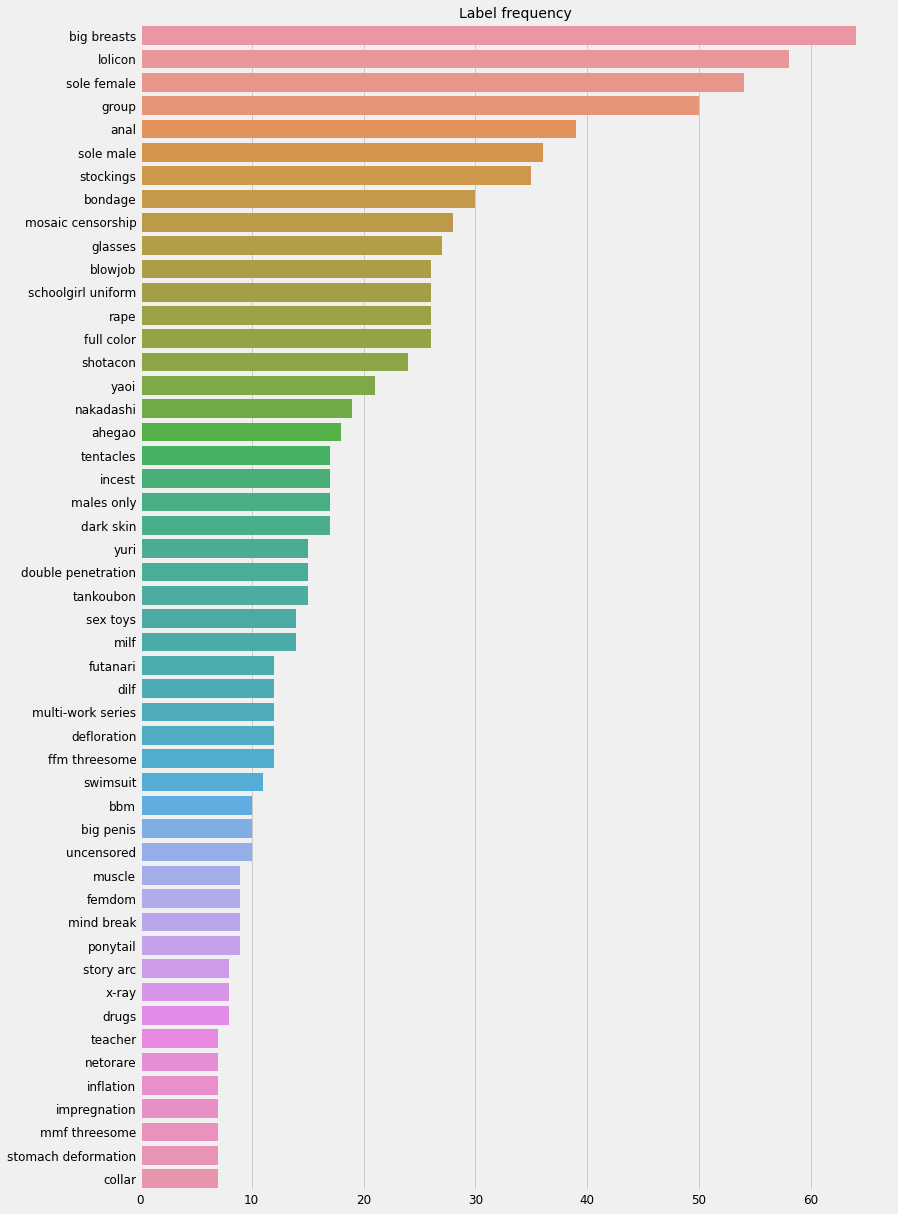

In [6]:
label_freq = hentais['tag'].explode().value_counts().sort_values(ascending=False).head(50)

style.use("fivethirtyeight")
plt.figure(figsize=(12, 20))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Data sparsity

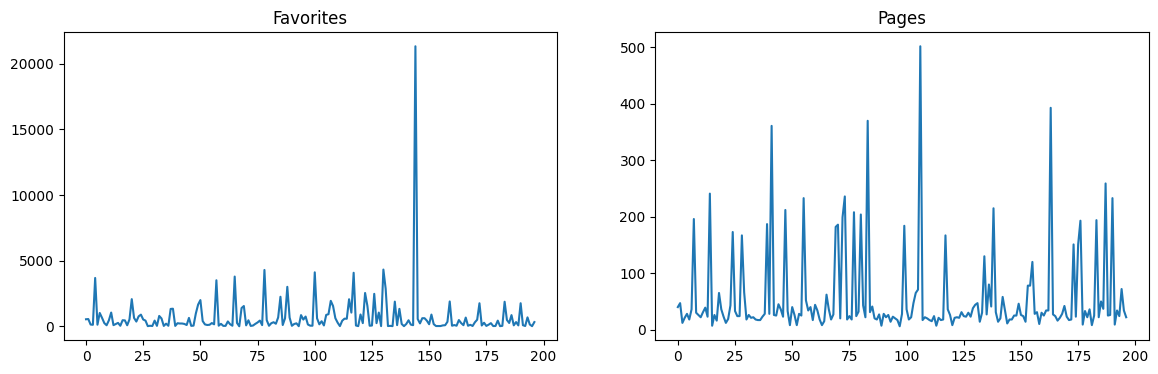

In [7]:

style.use("default")
plt.figure(figsize=(14, 4))
hentais["num_favorites"].plot(ax=plt.subplot(1, 2, 1), title="Favorites")
hentais["num_pages"].plot(ax=plt.subplot(1, 2, 2), title="Pages")
plt.show()

## Train / val split

We need to complete the full path to locate training and test images from the current working directory.


In [8]:
image_url_re = re.compile(r"https://i.nhentai.net/galleries/\d+")
filenames = hentais.apply(lambda x: [image_url_re.sub(os.path.join("data", str(x["id"])), img) for img in x["image_urls"]], axis=1).rename("filenames")
labels = hentais["tag"].rename("labels")
pd.concat([filenames, labels], axis=1)

,filenames,labels
0,"[data/119610/1.jpg, data/119610/2.jpg, data/11...","[sleeping, virginity, muscle, defloration, thi..."
1,"[data/182750/1.jpg, data/182750/2.jpg, data/18...","[glasses, big breasts, pasties, policewoman, r..."
2,"[data/270524/1.jpg, data/270524/2.jpg, data/27...","[lolicon, rape, tomboy, group, collar, sole fe..."
3,"[data/1215/1.jpg, data/1215/2.jpg, data/1215/3...","[futanari, big breasts, lactation]"
4,"[data/292757/1.jpg, data/292757/2.jpg, data/29...","[sole male, big breasts, sole female, multi-wo..."
...,...,...
192,"[data/85836/1.jpg, data/85836/2.jpg, data/8583...","[futanari, demon girl, lolicon]"
193,"[data/155485/1.jpg, data/155485/2.jpg, data/15...","[full color, incest, mosaic censorship, big br..."
194,"[data/29542/1.jpg, data/29542/2.jpg, data/2954...","[bdsm, asphyxiation, bondage, human pet, colla..."
195,"[data/102364/1.jpg, data/102364/2.jpg, data/10...","[elf, blood]"


Splitting the modeling data into training and validation is common in machine learning practice.
We will be allocating 80% of the images for training and 20% for validation.
Usually, we keep a final test set to communicate performance results but we will not really need it in this notebook.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(filenames, labels, test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  157
Number of posters for validation:  40


## Image examples

In [10]:
N_PREVIEW_OBJECTS = 8 # Maximum number of images to display
N_PREVIEW_COLUMNS = 4 # Number of columns in display
N_PREVIEW_ROWS = N_PREVIEW_OBJECTS // N_PREVIEW_COLUMNS # Number of rows in display


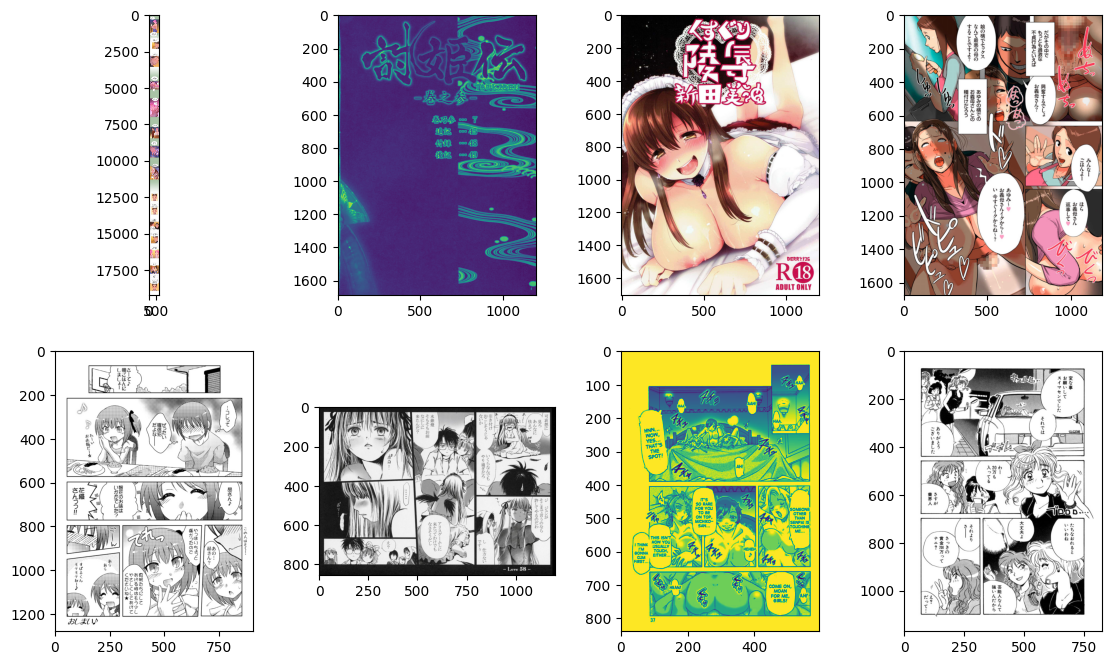

In [11]:

samples = X_train.explode().sample(N_PREVIEW_ROWS * N_PREVIEW_COLUMNS)

style.use("default")
plt.figure(figsize=(14, 4 * N_PREVIEW_ROWS))
for i, img in enumerate(samples):
    ax = plt.subplot(N_PREVIEW_ROWS, N_PREVIEW_COLUMNS, i+1)
    ax.imshow(plt.imread(img))

## Label encoding

The original targets are lists of strings that can be easily understood by humans.
But, if we want to build and train a neural network we need to create binary labels (multi-hot encoding).
This is critical for multi-label classification.

In order to binarize our labels, we will be using scikit-learn's MultiLabelBinarizer.

In [12]:
# Fit the multi-label binarizer on the training set
mlb = MultiLabelBinarizer()
mlb.fit(hentais['tag'])

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)

pd.DataFrame({'labels': mlb.classes_})

,labels
0,age regression
1,ahegao
2,all the way through
3,already uploaded
4,amputee
...,...
257,x-ray
258,yandere
259,yaoi
260,yuri


In [13]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

Let's check if everything worked correctly (We should obtain binary targets instead of list of strings).

In [14]:
# Print example of movie posters and their binary targets
pd.DataFrame(zip(X_train, y_train_bin), columns=["filename", "labels"])

,filename,labels
0,"[data/158272/1.jpg, data/158272/2.jpg, data/15...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[data/143070/1.jpg, data/143070/2.jpg, data/14...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[data/32053/1.jpg, data/32053/2.jpg, data/3205...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[data/272042/1.jpg, data/272042/2.jpg, data/27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[data/227928/1.jpg, data/227928/2.jpg, data/22...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
152,"[data/335108/1.jpg, data/335108/2.jpg, data/33...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
153,"[data/181919/1.jpg, data/181919/2.png, data/18...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
154,"[data/26867/1.jpg, data/26867/2.jpg, data/2686...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
155,"[data/306515/1.jpg, data/306515/2.jpg, data/30...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Tensorflow DataSet

In [15]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [16]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [17]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [18]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    filenames = filenames.apply(lambda x: x[1])
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [19]:

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

## Feature extractor

In [20]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
                                         trainable=False)

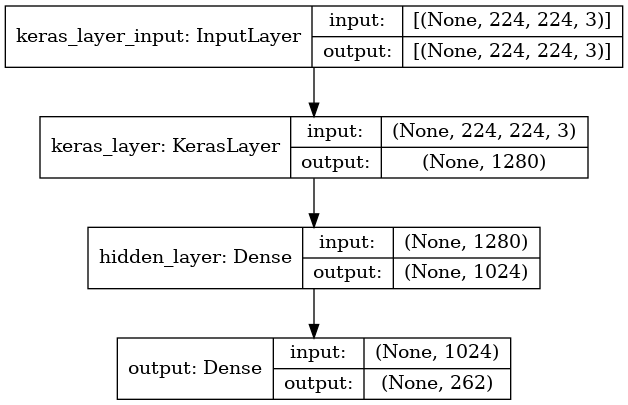

In [21]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='softmax', name='output')
])

keras.utils.plot_model(model,  show_shapes=True, show_layer_names=True)